In [177]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.fft import rfft, rfftfreq, fft
from scipy.signal import butter, filtfilt, find_peaks, lfilter
from scipy.ndimage import median_filter


In [178]:
# Parameters for recording
CHUNK = 1024            # Number of audio samples per buffer
FORMAT = pyaudio.paInt16  # each sample is 16 bit
CHANNELS = 1            # Mono audio
RATE = 44100            # Sampling rate in Hz -> how many samples per second
RECORD_SECONDS = 5      # Duration of recording in seconds
AUDIO_FILE = './utils/assets/lewis_capaldi.mp3'
NUMBER_OF_CHUNKS = int(RATE / CHUNK * RECORD_SECONDS)

In [179]:

def from_raw_to_array_of_chunks(raw_audio_data):
    return [raw_audio_data[i:i + CHUNK] for i in range(0, len(raw_audio_data), CHUNK)]
   
def from_array_of_chunks_to_array_of_int(array_of_chunks):
    return np.frombuffer(b''.join(array_of_chunks), dtype=np.int16)

def from_mp3(file_path):

    audio_file_path = file_path  # Replace with your MP3 file path
    audio = AudioSegment.from_mp3(audio_file_path)
    
    # Convert the audio to raw PCM data (in this case, 16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw bytes
    raw_audio_data = audio.raw_data
    
    # Process the audio data in chunks as you would with live input
    frames = from_raw_to_array_of_chunks(raw_audio_data)
    
    return from_array_of_chunks_to_array_of_int(frames)
    

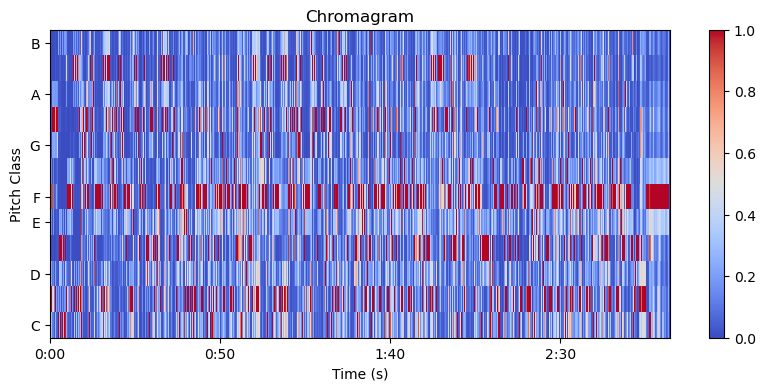

In [180]:
y, sr = librosa.load(AUDIO_FILE, dtype="float32")

# Compute the chromagram
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Display the chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar()
plt.title("Chromagram")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

# GPT

In [181]:
from librosa.core.spectrum import stft
from librosa.core.pitch import estimate_tuning
from librosa import filters
from librosa import util

def chroma_stft(
    *,
    y = None,
    sr: float = 22050,
    S = None,
    norm= np.inf,
    n_fft: int = 2048,
    hop_length: int = 512,
    win_length= None,
    window = "hann",
    center: bool = True,
    pad_mode = "constant",
    tuning= None,
    n_chroma: int = 12,
    **kwargs,
) -> np.ndarray:
    """Compute a chromagram from a waveform or power spectrogram.
    Parameters
    ----------
    y : np.ndarray [shape=(..., n)] or None
        audio time series. Multi-channel is supported.
    sr : number > 0 [scalar]
        sampling rate of ``y``
    S : np.ndarray [shape=(..., d, t)] or None
        power spectrogram
    norm : float or None
        Column-wise normalization.
        See `librosa.util.normalize` for details.
        If `None`, no normalization is performed.
    n_fft : int  > 0 [scalar]
        FFT window size if provided ``y, sr`` instead of ``S``
    hop_length : int > 0 [scalar]
        hop length if provided ``y, sr`` instead of ``S``
    win_length : int <= n_fft [scalar]
        Each frame of audio is windowed by `window()`.
        The window will be of length `win_length` and then padded
        with zeros to match ``n_fft``.
        If unspecified, defaults to ``win_length = n_fft``.
    window : string, tuple, number, function, or np.ndarray [shape=(n_fft,)]
        - a window specification (string, tuple, or number);
          see `scipy.signal.get_window`
        - a window function, such as `scipy.signal.windows.hann`
        - a vector or array of length ``n_fft``
        .. see also:: `librosa.filters.get_window`
    center : boolean
        - If `True`, the signal ``y`` is padded so that frame
          ``t`` is centered at ``y[t * hop_length]``.
        - If `False`, then frame ``t`` begins at ``y[t * hop_length]``
    pad_mode : string
        If ``center=True``, the padding mode to use at the edges of the signal.
        By default, STFT uses zero padding.
    tuning : float [scalar] or None.
        Deviation from A440 tuning in fractional chroma bins.
        If `None`, it is automatically estimated.
    n_chroma : int > 0 [scalar]
        Number of chroma bins to produce (12 by default).
    **kwargs : additional keyword arguments to parameterize chroma filters.
    ctroct : float > 0 [scalar]
    octwidth : float > 0 or None [scalar]
        ``ctroct`` and ``octwidth`` specify a dominance window:
        a Gaussian weighting centered on ``ctroct`` (in octs, A0 = 27.5Hz)
        and with a gaussian half-width of ``octwidth``.
        Set ``octwidth`` to `None` to use a flat weighting.
    norm : float > 0 or np.inf
        Normalization factor for each filter
    base_c : bool
        If True, the filter bank will start at 'C'.
        If False, the filter bank will start at 'A'.
    dtype : np.dtype
        The data type of the output basis.
        By default, uses 32-bit (single-precision) floating point.
    """
    POWER = 2
    S = (
            np.abs(
                stft(
                    y,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    win_length=win_length,
                    center=center,
                    window=window,
                    pad_mode=pad_mode,
                )
            )
            ** POWER
        )

    if tuning is None:
        tuning = estimate_tuning(S=S, sr=sr, bins_per_octave=n_chroma)

    # Get the filter bank
    chromafb = filters.chroma(
        sr=sr, n_fft=n_fft, tuning=tuning, n_chroma=n_chroma, **kwargs
    )

    # Compute raw chroma
    # EQUIVALENT TO raw_chroma = np.dot(chromafb, S)
    # (bins , frequencies) x (frequencies, time) -> (bins, time)
    raw_chroma = np.einsum("cf,...ft->...ct", chromafb, S, optimize=True)
    
    # Compute normalization factor for each frame
    return util.normalize(raw_chroma, norm=norm, axis=-2)


In [182]:
def display_chromagram(chroma):
    plt.figure(figsize=(20, 4))
    librosa.display.specshow(chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
    plt.colorbar(label="Magnitude")
    plt.title("Chromagram (Using Custom chroma_stft Function)")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch Class")
    plt.show()

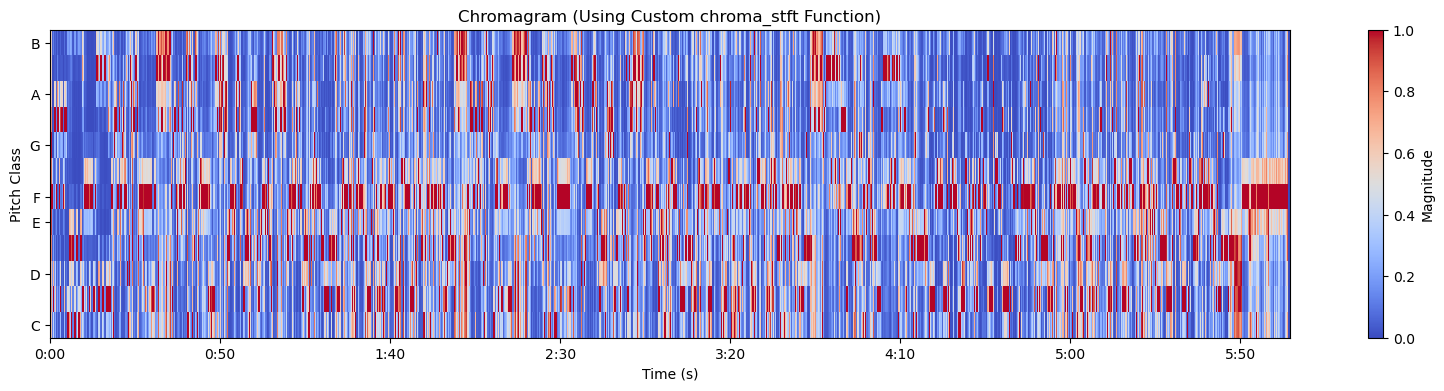

In [183]:
import numpy as np
import matplotlib.pyplot as plt

def from_mp3(file_path):
    audio = AudioSegment.from_mp3(file_path)
    audio = audio.set_channels(1)
    audio = audio.set_frame_rate(RATE)
    raw_audio_data = np.frombuffer(audio.raw_data, dtype=np.int16)
    return raw_audio_data.astype(np.float32) / np.iinfo(np.int16).max  # Normalize to [-1,1]

# Load Audio
sample_rate = RATE
audio = from_mp3(AUDIO_FILE)

# STFT Parameters
window_size = 2048
hop_size = 512

# Compute Chroma using your function
chroma = chroma_stft(y=audio, sr=sample_rate)

display_chromagram(chroma)


In [184]:
import numpy as np

def time_to_index(time, sr, hop_length):
    """
    Converts time to index.

    Parameters:
    - time (float): Time in seconds.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - int: Index corresponding to the time.
    """
    time_per_column = hop_length / sr
    return int(time / time_per_column)
def index_to_time(index, sr, hop_length):
    """
    Converts index to time.

    Parameters:
    - index (int): Index.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - float: Time in seconds corresponding to the index.
    """
    time_per_column = hop_length / sr
    return index * time_per_column

def cut_time(chroma_matrix, start_time, end_time, sr, hop_length):
    """
    Cuts a time segment from a chroma matrix.

    Parameters:
    - chroma_matrix (np.ndarray): The chroma matrix (shape: 12 x num_time_frames).
    - start_time (float): The start time in seconds.
    - end_time (float): The end time in seconds.
    - sr (int): Sampling rate of the audio.
    - hop_length (int): Hop size used in STFT.

    Returns:
    - np.ndarray: Cropped chroma matrix.
    """

    # Convert times to indices
    start_index = time_to_index(start_time, sr, hop_length)
    end_index = time_to_index(end_time, sr, hop_length)

    # Ensure indices are within bounds
    start_index = max(0, start_index)
    end_index = min(chroma_matrix.shape[1], end_index)

    # Slice the chroma matrix
    return chroma_matrix[:, start_index:end_index]

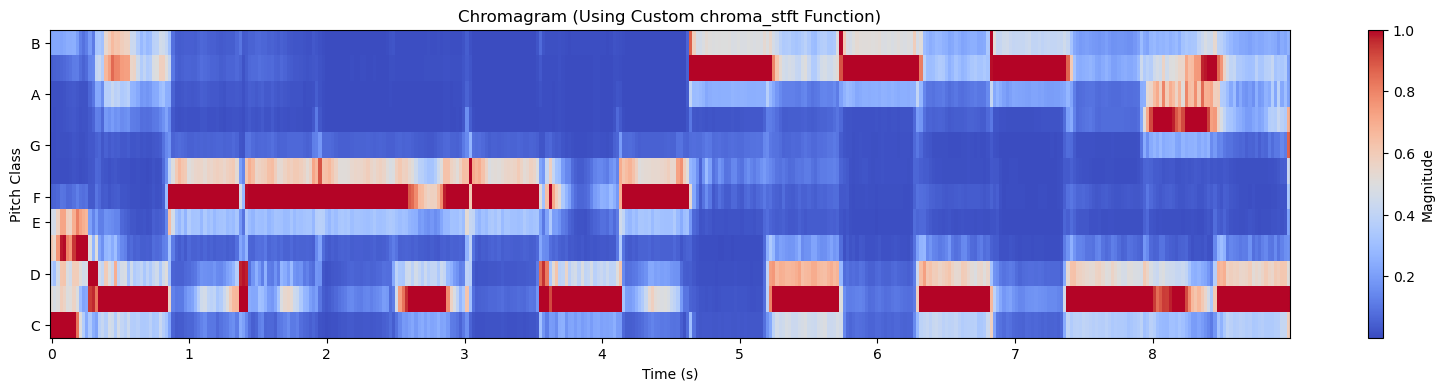

In [185]:
cut_chroma = cut_time(chroma , 9, 18, sr, hop_size)
display_chromagram(cut_chroma)

In [186]:
time_to_index(9, sr, hop_size)

387

In [187]:
idx = time_to_index(10, sr, hop_size)
frequencies = chroma[:, idx]

In [188]:
frequencies

array([0.06163417, 0.19219355, 0.0740917 , 0.06386517, 0.3565765 ,
       1.        , 0.50765073, 0.04742005, 0.01326385, 0.02887637,
       0.05591308, 0.0455155 ], dtype=float32)

In [189]:
notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
note = notes[np.argmax(frequencies)]

In [190]:
note

'F'

In [191]:
def get_note_from_second(chroma, second,hop_size, sr):
    idx = time_to_index(second, sr, hop_size)
    frequencies = chroma[:, idx]
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    return notes[np.argmax(frequencies)]

In [192]:
get_note_from_second(chroma, 9.4, hop_size, sr)

'C#'

In [193]:
def get_note_from_time(chroma, hop_size, sr, min, sec, millisec=0):
    return get_note_from_second(chroma, min * 60 + sec + millisec / 1000, hop_size, sr)

In [194]:
get_note_from_time(chroma, hop_size, sr, min=0, sec=9, millisec=400)

'C#'

# Reducing horizontal noise
 Our chroma matrix is nothing else than a 2d signal. We can apply filters to it to smooth it out.
 Here I'm trying two different filters: median and gaussian.

In [195]:
from scipy.ndimage import median_filter, gaussian_filter

def smooth_chroma_median(chroma_matrix, kernel_size=3):
    
    return median_filter(chroma_matrix, size=(1, kernel_size))  # Apply along time axis

def smooth_chroma_gaussian(chroma_matrix, sigma=1):
   
    return gaussian_filter(chroma_matrix, sigma=(0, sigma))  # Apply along time axis


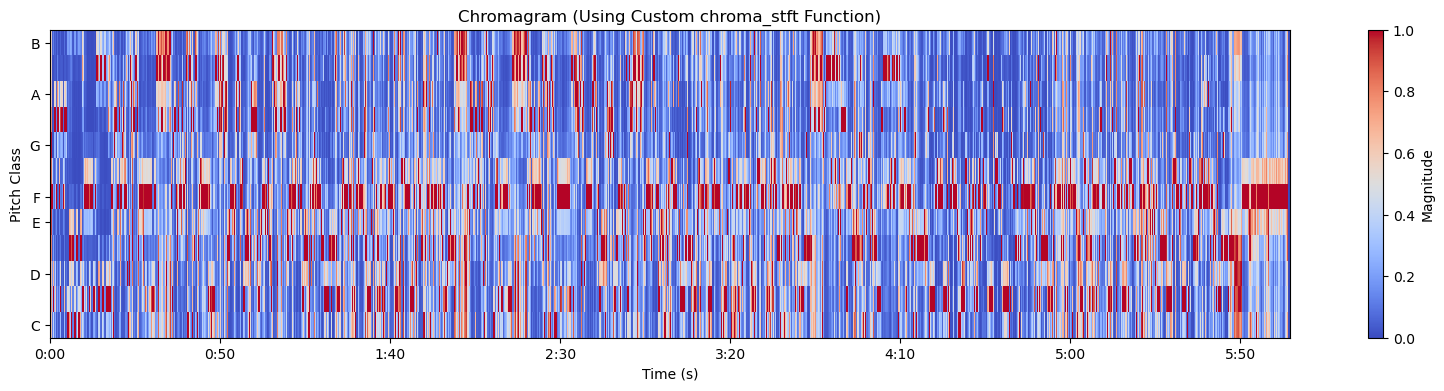

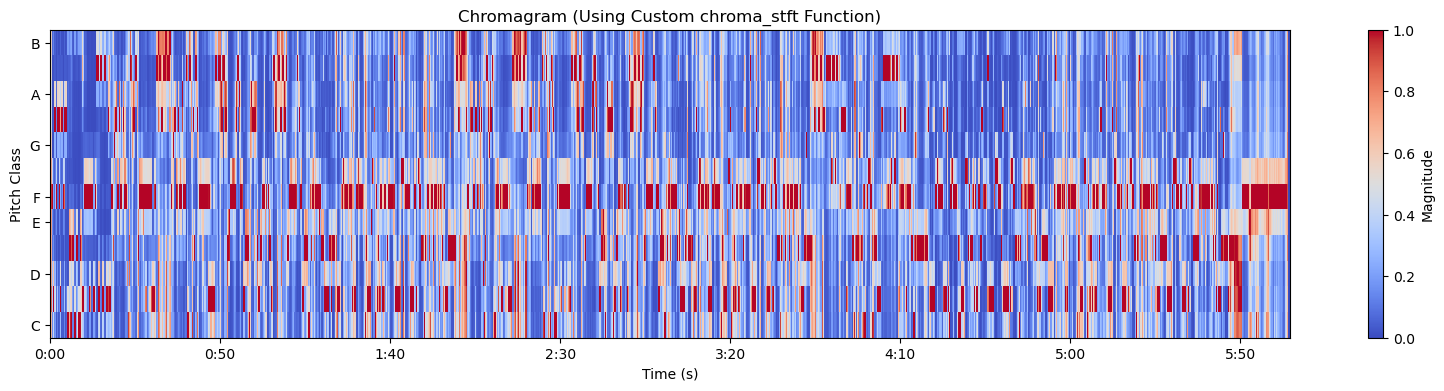

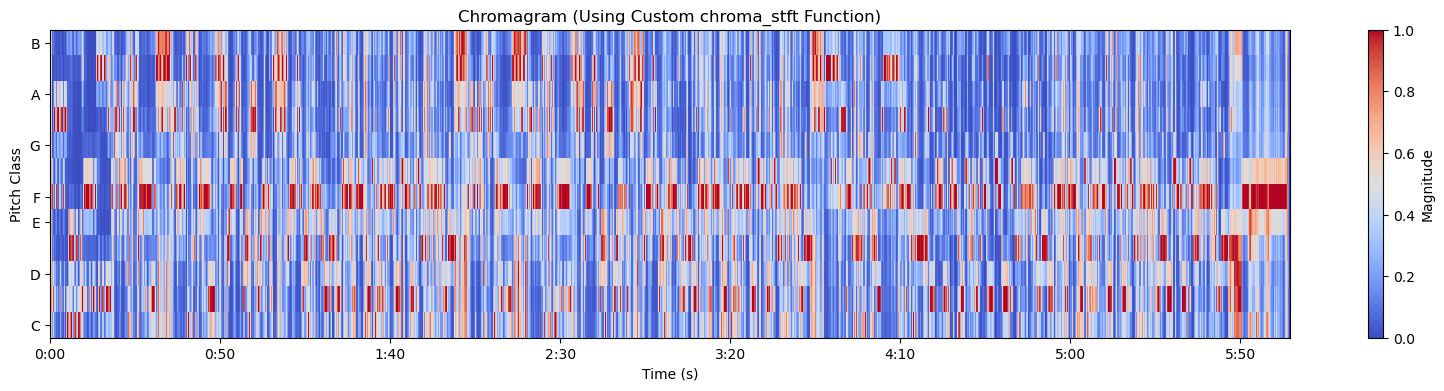

In [196]:
median_smoothed_chroma = smooth_chroma_median(chroma, kernel_size=16)
gaussian_smoothed_chroma = smooth_chroma_gaussian(chroma, sigma=4) 

display_chromagram(chroma)
display_chromagram(median_smoothed_chroma)
display_chromagram(gaussian_smoothed_chroma)


In [205]:
chord_timestamps = []
for column, frequencies in enumerate(chroma.T):
    chord = notes[np.argmax(frequencies)]
    start_chord = index_to_time(column, sr, hop_size)
    end_chord = index_to_time(column + 1, sr, hop_size)
    chord_timestamps.append((chord, start_chord, end_chord))
    
chord_timestamps[:10]

[('C', 0.0, 0.023219954648526078),
 ('C', 0.023219954648526078, 0.046439909297052155),
 ('C', 0.046439909297052155, 0.06965986394557823),
 ('C', 0.06965986394557823, 0.09287981859410431),
 ('C', 0.09287981859410431, 0.11609977324263039),
 ('C', 0.11609977324263039, 0.13931972789115646),
 ('C', 0.13931972789115646, 0.16253968253968254),
 ('C', 0.16253968253968254, 0.18575963718820862),
 ('C', 0.18575963718820862, 0.2089795918367347),
 ('C', 0.2089795918367347, 0.23219954648526078)]

In [206]:
CHORDS = {
    # Major chords (Root, Major third, Perfect fifth)
    (48, 52, 55): "C Major",
    (49, 53, 56): "C# Major / Db Major",
    (50, 54, 57): "D Major",
    (51, 55, 58): "D# Major / Eb Major",
    (52, 56, 59): "E Major",
    (53, 57, 60): "F Major",
    (54, 58, 61): "F# Major / Gb Major",
    (55, 59, 62): "G Major",
    (56, 60, 63): "G# Major / Ab Major",
    (57, 61, 64): "A Major",
    (58, 62, 65): "A# Major / Bb Major",
    (59, 63, 66): "B Major",

    # Minor chords (Root, Minor third, Perfect fifth)
    (48, 51, 55): "C Minor",
    (49, 52, 56): "C# Minor / Db Minor",
    (50, 53, 57): "D Minor",
    (51, 54, 58): "D# Minor / Eb Minor",
    (52, 55, 59): "E Minor",
    (53, 56, 60): "F Minor",
    (54, 57, 61): "F# Minor / Gb Minor",
    (55, 58, 62): "G Minor",
    (56, 59, 63): "G# Minor / Ab Minor",
    (57, 60, 64): "A Minor",
    (58, 61, 65): "A# Minor / Bb Minor",
    (59, 62, 66): "B Minor",

    # Diminished chords (Root, Minor third, Diminished fifth)
    (48, 51, 54): "C Diminished",
    (49, 52, 55): "C# Diminished / Db Diminished",
    (50, 53, 56): "D Diminished",
    (51, 54, 57): "D# Diminished / Eb Diminished",
    (52, 55, 58): "E Diminished",
    (53, 56, 59): "F Diminished",
    (54, 57, 60): "F# Diminished / Gb Diminished",
    (55, 58, 61): "G Diminished",
    (56, 59, 62): "G# Diminished / Ab Diminished",
    (57, 60, 63): "A Diminished",
    (58, 61, 64): "A# Diminished / Bb Diminished",
    (59, 62, 65): "B Diminished",

    # Augmented chords (Root, Major third, Augmented fifth)
    (48, 52, 56): "C Augmented",
    (49, 53, 57): "C# Augmented / Db Augmented",
    (50, 54, 58): "D Augmented",
    (51, 55, 59): "D# Augmented / Eb Augmented",
    (52, 56, 60): "E Augmented",
    (53, 57, 61): "F Augmented",
    (54, 58, 62): "F# Augmented / Gb Augmented",
    (55, 59, 63): "G Augmented",
    (56, 60, 64): "G# Augmented / Ab Augmented",
    (57, 61, 65): "A Augmented",
    (58, 62, 66): "A# Augmented / Bb Augmented",
    (59, 63, 67): "B Augmented",

    # Major 7th chords (Root, Major third, Perfect fifth, Major seventh)
    (48, 52, 55, 59): "C Major 7",
    (50, 54, 57, 61): "D Major 7",
    (52, 56, 59, 63): "E Major 7",
    (53, 57, 60, 64): "F Major 7",
    (55, 59, 62, 66): "G Major 7",
    (57, 61, 64, 68): "A Major 7",
    (59, 63, 66, 70): "B Major 7",

    # Minor 7th chords (Root, Minor third, Perfect fifth, Minor seventh)
    (48, 51, 55, 58): "C Minor 7",
    (50, 53, 57, 60): "D Minor 7",
    (52, 55, 59, 62): "E Minor 7",
    (53, 56, 60, 63): "F Minor 7",
    (55, 58, 62, 65): "G Minor 7",
    (57, 60, 64, 67): "A Minor 7",
    (59, 62, 66, 69): "B Minor 7",

    # Dominant 7th chords (Root, Major third, Perfect fifth, Minor seventh)
    (48, 52, 55, 58): "C Dominant 7",
    (50, 54, 57, 60): "D Dominant 7",
    (52, 56, 59, 62): "E Dominant 7",
    (53, 57, 60, 63): "F Dominant 7",
    (55, 59, 62, 65): "G Dominant 7",
    (57, 61, 64, 67): "A Dominant 7",
    (59, 63, 66, 69): "B Dominant 7",
}

In [212]:
import numpy as np
import time

import fluidsynth

# Initialize FluidSynth
def play_result(chords_timestamps):
    fs = fluidsynth.Synth()
    fs.start(driver="coreaudio")  # Use the appropriate driver for your OS (e.g., "coreaudio" for macOS)
    sfid = fs.sfload("utils/piano/SalC5Light2.sf2")  # Load a SoundFont file (replace with a valid .sf2 file)
    fs.program_select(0, sfid, 0, 0)  # Select instrument (0 = default piano)
    
    def transform_chords_dict(chords_dict):
        """
        Transforms the given CHORDS dictionary into a CHORD_NOTES dictionary 
        where the chord names are keys and the corresponding MIDI note tuples are values.
        """
        return {name: notes for notes, name in chords_dict.items()}
    
    
    # Transform dictionary
    #CHORD_NOTES = transform_chords_dict(CHORDS)
    CHORD_NOTES = {
    "C":  [60, 64, 67],   # C - E - G
    "C#": [61, 65, 68],   # C# - F - G#
    "D":  [62, 66, 69],   # D - F# - A
    "D#": [63, 67, 70],   # D# - G - A#
    "E":  [64, 68, 71],   # E - G# - B
    "F":  [65, 69, 72],   # F - A - C
    "F#": [66, 70, 73],   # F# - A# - C#
    "G":  [67, 71, 74],   # G - B - D
    "G#": [68, 72, 75],   # G# - C - D#
    "A":  [69, 73, 76],   # A - C# - E
    "A#": [70, 74, 77],   # A# - D - F
    "B":  [71, 75, 78],   # B - D# - F#
}

    # Play detected chords
    for chord, start, end in chords_timestamps:
        if chord in CHORD_NOTES:
            notes = CHORD_NOTES[chord]
            print(f"Playing: {chord}, Notes: {notes}, Start: {start:.2f}, End: {end:.2f}")
    
            # Play notes
            for note in notes:
                fs.noteon(0, note, 100)  # Channel 0, Note number, Velocity
    
            time.sleep(end-start)  # Hold the chord for 1 second
    
            # Stop notes
            for note in notes:
                fs.noteoff(0, note)
    
            time.sleep(0.2)  # Short pause between chords
    
    # Shutdown FluidSynth
    fs.delete()

In [213]:
def cut_short_frames(chord_timestamps, upper_bound):
    """
    Removes chord timestamps with a duration shorter than `upper_bound`,
    but only if the chord is different from both the previous and next chord.

    Parameters:
    - chord_timestamps (list of tuples): List of (chord, start_time, end_time).
    - upper_bound (float): Minimum allowed duration (in seconds).

    Returns:
    - list of tuples: Filtered list with short chords removed if different from neighbors.
    """
    if not chord_timestamps:
        return []

    filtered_chords = []
    
    for i, (chord, start, end) in enumerate(chord_timestamps):
        duration = end - start

        # If duration is long enough, keep it
        if duration >= upper_bound:
            filtered_chords.append((chord, start, end))
            continue

        # Check neighbors
        prev_chord = chord_timestamps[i-1][0] if i > 0 else None
        next_chord = chord_timestamps[i+1][0] if i < len(chord_timestamps) - 1 else None

        # Remove if different from both neighbors
        if chord != prev_chord and chord != next_chord:
            continue  # Skip adding this chord

        # Otherwise, keep it
        filtered_chords.append((chord, start, end))

    return filtered_chords



In [214]:
def unify_chords(chord_timestamps):
    """
    Merges consecutive identical chords by updating their end times.

    Parameters:
    - chord_timestamps (list of tuples): List of (chord, start_time, end_time).

    Returns:
    - list of tuples: Merged chord timestamps.
    """
    if not chord_timestamps:
        return []

    merged_chords = []
    prev_chord, start_time, end_time = chord_timestamps[0]

    for i in range(1, len(chord_timestamps)):
        chord, start, end = chord_timestamps[i]

        # If the current chord is the same as the previous one, extend the duration
        if chord == prev_chord:
            end_time = end  # Update end time
        else:
            # Save the previous chord and start a new one
            merged_chords.append((prev_chord, start_time, end_time))
            prev_chord, start_time, end_time = chord, start, end

    # Append the last chord
    merged_chords.append((prev_chord, start_time, end_time))

    return merged_chords

In [218]:
merged_chords = cut_short_frames(unify_chords(chord_timestamps), 1)

In [219]:
play_result(merged_chords)

Playing: F, Notes: [65, 69, 72], Start: 10.43, End: 11.59
Playing: F, Notes: [65, 69, 72], Start: 45.09, End: 46.42
Playing: C#, Notes: [61, 65, 68], Start: 47.48, End: 48.53
Playing: F, Notes: [65, 69, 72], Start: 91.12, End: 92.14
Playing: D#, Notes: [63, 67, 70], Start: 117.77, End: 118.84
Playing: F, Notes: [65, 69, 72], Start: 150.53, End: 152.23
Playing: F, Notes: [65, 69, 72], Start: 157.69, End: 158.96
Playing: F, Notes: [65, 69, 72], Start: 175.12, End: 176.56
Playing: D#, Notes: [63, 67, 70], Start: 222.52, End: 223.56
Playing: A#, Notes: [70, 74, 77], Start: 228.07, End: 229.65
Playing: C#, Notes: [61, 65, 68], Start: 243.25, End: 244.32
Playing: D#, Notes: [63, 67, 70], Start: 255.91, End: 256.93
Playing: C#, Notes: [61, 65, 68], Start: 280.40, End: 281.68
Playing: F, Notes: [65, 69, 72], Start: 296.17, End: 297.33
Playing: C#, Notes: [61, 65, 68], Start: 328.47, End: 329.77
Playing: C#, Notes: [61, 65, 68], Start: 332.79, End: 334.07
Playing: D#, Notes: [63, 67, 70], Start